# 손으로 쓴 숫자 훈련

In [1]:
from google.colab import drive
drive.mount('mount')

Mounted at mount


In [2]:
%cd './mount/MyDrive/Colab Notebooks/myo_gan/'

/content/mount/MyDrive/Colab Notebooks/myo_gan


In [3]:
%run '단순 1010 패턴.ipynb'

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

import pandas as pd
import matplotlib.pyplot as plt

## 데이터셋 클래스

In [5]:
class MnistDataset(Dataset):
    def __init__(self, csv_file):
        self.data_df = pd.read_csv(csv_file, header=None)

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        label = self.data_df.iloc[index, 0]
        target = torch.zeros((10))
        target[label] = 1.0

        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values)/255.0
        return label, image_values, target

    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28, 28)
        plt.title('label = ' + str(self.data_df.iloc[index, 0]))
        plt.imshow(img, interpolation='none', cmap='Blues')

In [6]:
mnist_dataset = MnistDataset('mnist_train.csv')

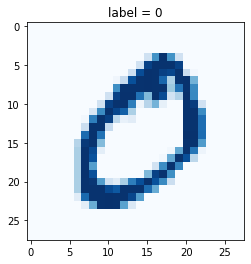

In [ ]:
mnist_dataset.plot_image(1)

## MNIST 판별기

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.Sigmoid(),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )

        self.loss_function = nn.MSELoss()

        self.optimiser = optim.SGD(self.parameters(), lr=0.01)

        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, inputs, targets):
        outputs = self.forward(inputs)

        loss = self.loss_function(outputs, targets)

        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())
        
        if self.counter % 10000 == 0:
            print('counter = ', self.counter)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))

## 판별기 테스트하기

In [ ]:
D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    D.train(generate_random(784), torch.FloatTensor([0.0]))

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000


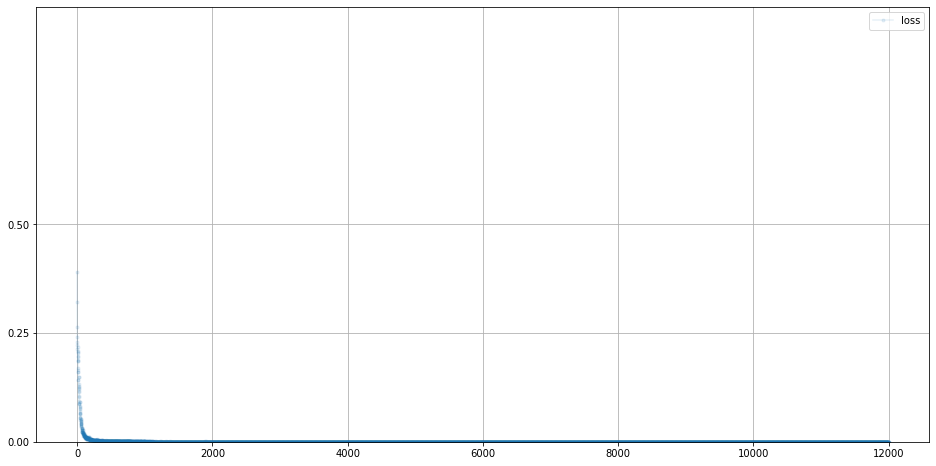

In [ ]:
D.plot_progress()

In [ ]:
for i in range(4):
    image_data_tensor = mnist_dataset[random.randint(0, 60000)][1]
    print(D.forward(image_data_tensor).item())

for i in range(4):
    print(D.forward(generate_random(784)).item())

0.9855076670646667
0.9977363348007202
0.9980303645133972
0.9965351819992065
0.006053355056792498
0.006872393656522036
0.006312312558293343
0.006005707662552595


## MNIST 생성기

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(1, 200),
            nn.Sigmoid(),
            nn.Linear(200, 784),
            nn.Sigmoid()
        )

        self.optimiser = optim.SGD(self.parameters(), lr=0.01)

        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)

        d_output = D.forward(g_output)

        loss = D.loss_function(d_output, targets)
        
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))

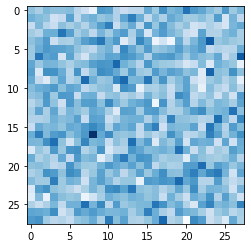

In [ ]:
G = Generator()

output = G.forward(generate_random(1))
img = output.detach().numpy().reshape(28, 28)
plt.imshow(img, interpolation='none', cmap='Blues')

## GAN 훈련하기

In [ ]:
D = Discriminator()
G = Generator()

for label, image_data_tensor, target_tensor in mnist_dataset:
    
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))
    
    G.train(D, generate_random(1), torch.FloatTensor([1.0]))

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000


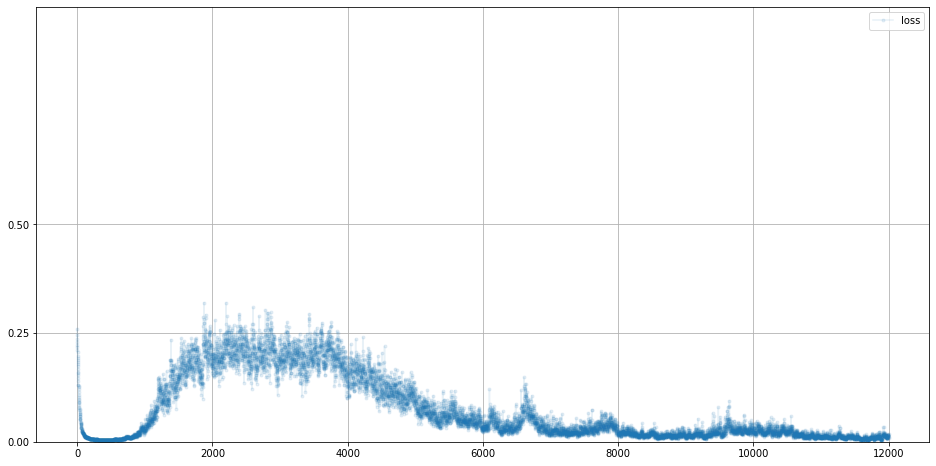

In [ ]:
D.plot_progress()

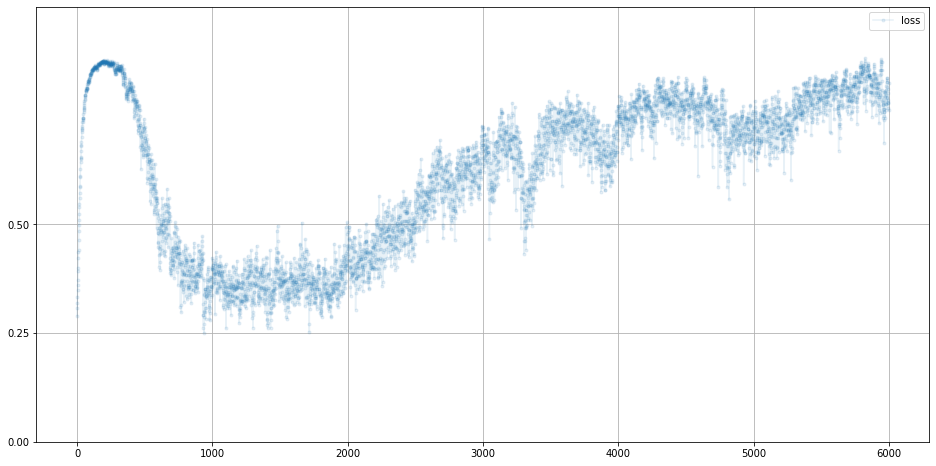

In [ ]:
G.plot_progress()

초기에 손실값이 치솟아 오르는데 이는 판별기가 생성기에서 나온 이미지를 잘 구분하기 때문

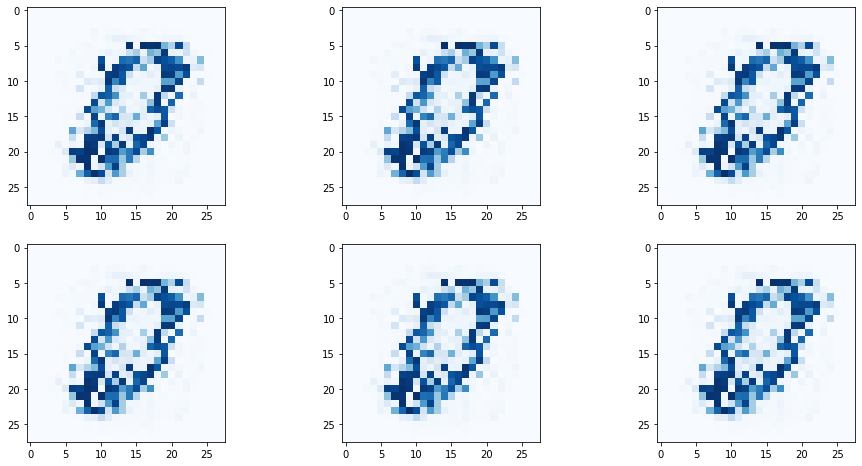

In [ ]:
f, axarr = plt.subplots(2, 3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G.forward(generate_random(1))
        img = output.detach().numpy().reshape(28, 28)
        axarr[i, j].imshow(img, interpolation='none', cmap='Blues')

## 모드 붕괴
생성기가 여러 label들에 대해 다양하게 생성하지 못하고 오직 하나의 값만을 만들거나 극히 일부만 만드는 현상

## GAN 훈련 성능 향상하기

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )

        self.loss_function = nn.BCELoss()

        self.optimiser = optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, inputs, targets):
        outputs = self.forward(inputs)

        loss = self.loss_function(outputs, targets)

        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())
        
        if self.counter % 10000 == 0:
            print('counter = ', self.counter)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(100, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 784),
            nn.Sigmoid()
        )

        self.optimiser = optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)

        d_output = D.forward(g_output)

        loss = D.loss_function(d_output, targets)
        
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

In [11]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [ ]:
D = Discriminator()
G = Generator()

for label, image_data_tensor, target_tensor in mnist_dataset:
    
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
    
    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000


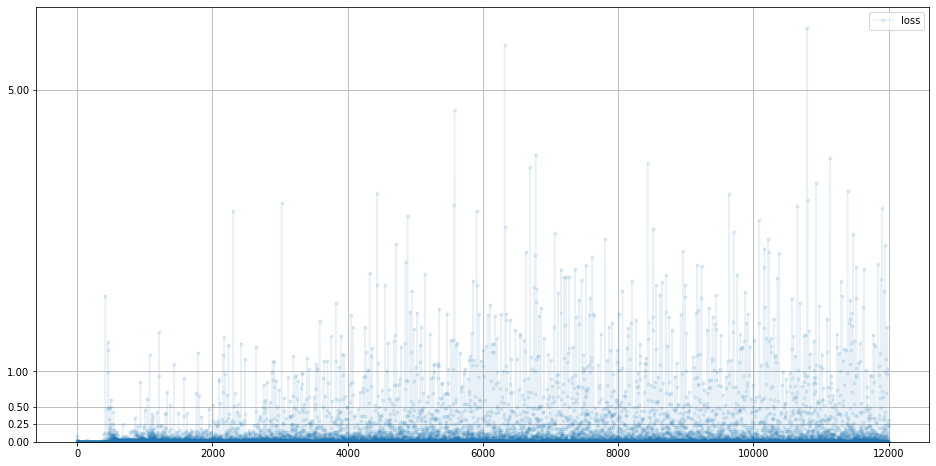

In [ ]:
D.plot_progress()

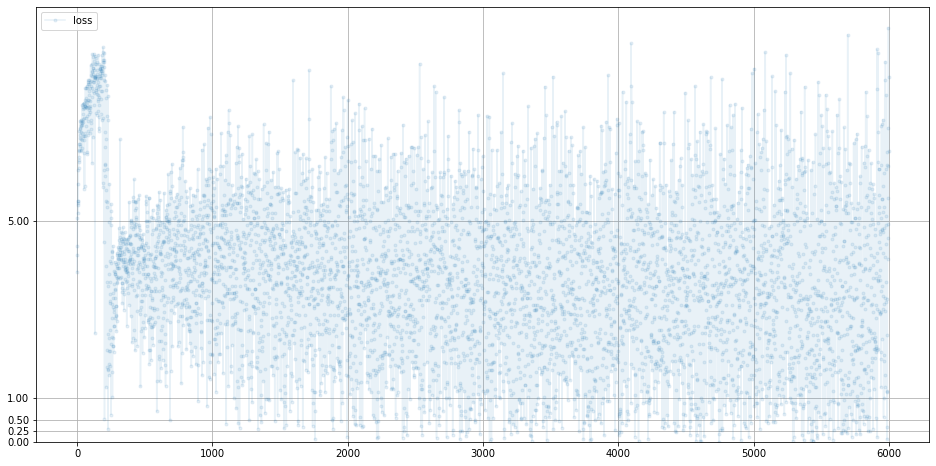

In [ ]:
G.plot_progress()

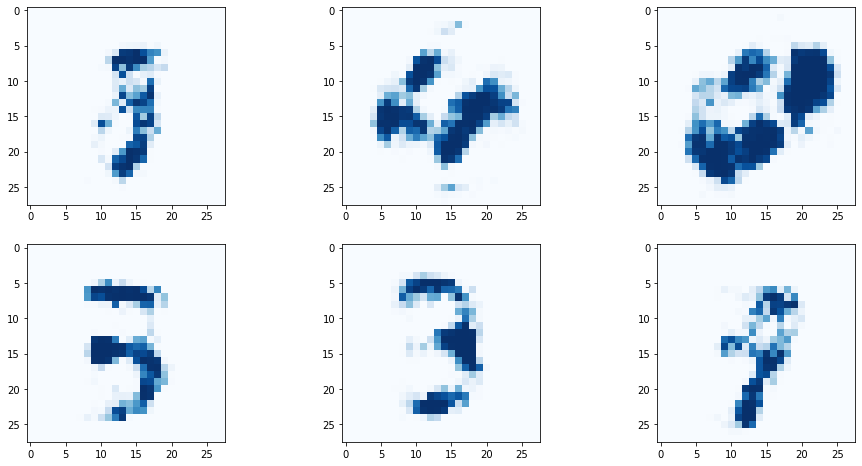

In [ ]:
f, axarr = plt.subplots(2, 3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().numpy().reshape(28, 28)
        axarr[i, j].imshow(img, interpolation='none', cmap='Blues')